# Sustainability Anlysis

# 1 Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import PyPDF2
import string
import unicodedata
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 2 Convert Sustainability Reports to Text Files

In [38]:
def report_to_text(report):
    """Create a text string of pdf-file content"""
    pdfFileObj = open(f"Reports/{report}.pdf", "rb")
    pdfReader = PyPDF2.PdfReader(pdfFileObj)
    no_pages = len(pdfReader.pages)

    report_text = ""
    for i in range(0,no_pages):
        pageObj = pdfReader.pages[i]
        report_text += pageObj.extract_text()
    
    return report_text

In [ ]:
file_names = os.listdir("Reports")
report_file_names = [f[:-4] for f in file_names if f[-4:] == ".pdf"]

for report in tqdm(report_file_names):
    report_text = report_to_text(report)
    print(report)
    f = open(f"Reports_text/{report}.txt", "a")
    f.write(report_text)
    f.close()

# 3 Create Sustainability Report Table 

In [41]:
# Create an empty table
report_table = pd.DataFrame(columns=["report_name", "content"])
# List text files in directory
file_names = os.listdir("reports_text")
text_file_names = [f[:-4] for f in file_names if f[-4:] == ".txt"]
# Append report name and report text for each report
for text_file_name in text_file_names:
    # Read text from report text file
    text_file = open(f"reports_text/{text_file_name}.txt", "r")
    content = text_file.read()
    content = (content
               .replace("\n", " ").replace("\r", " ").replace("\t", " ")
               .replace(",", "").replace(".", "").replace(":", "")
               .replace(";", "").replace("-", " ").replace("|", " ")
               .replace("(", "").replace(")", "").replace("?", "")
               .replace("!", "").replace("\'", "").replace('\"', ""))
    # print(content)
    text_file.close()    
    # Append report name and text to table
    report_row = pd.DataFrame([[text_file_name [:-5], content]], columns=["report_name", "content"])
    report_table = pd.concat([report_table, report_row],  axis=0, ignore_index=True)
# Save table as csv file
report_table.to_csv("reports.csv", index=False)

In [42]:
report_table.head()

,report_name,content
0,TRADERA,Climate Impact Report 2021 This is Traderas th...
1,SWEDBANK,1 SUSTAINABILITY POLICY Adopted by ...
2,HTC,ESG Repo rt 2022Environment Social Governance...
3,FISKARS,Sustainability Report 2022Contents Message fro...
4,KJELL & COMPANY,Kjell & Company ESG impacts throu...


# 4 Read Loughran-McDonald MasterD ictionary

In [14]:
master_dictionary = pd.read_csv("Loughran-McDonald_MasterDictionary_1993-2021.csv")

In [15]:
postive_words = master_dictionary[master_dictionary.Positive != 0]["Word"].to_list()
postive_words[:20]

['ABLE',
 'ABUNDANCE',
 'ABUNDANT',
 'ACCLAIMED',
 'ACCOMPLISH',
 'ACCOMPLISHED',
 'ACCOMPLISHES',
 'ACCOMPLISHING',
 'ACCOMPLISHMENT',
 'ACCOMPLISHMENTS',
 'ACHIEVE',
 'ACHIEVED',
 'ACHIEVEMENT',
 'ACHIEVEMENTS',
 'ACHIEVES',
 'ACHIEVING',
 'ADEQUATELY',
 'ADVANCEMENT',
 'ADVANCEMENTS',
 'ADVANCES']

In [16]:
negative_words = master_dictionary[master_dictionary.Negative != 0]["Word"].to_list()
negative_words[:20]

['ABANDON',
 'ABANDONED',
 'ABANDONING',
 'ABANDONMENT',
 'ABANDONMENTS',
 'ABANDONS',
 'ABDICATED',
 'ABDICATES',
 'ABDICATING',
 'ABDICATION',
 'ABDICATIONS',
 'ABERRANT',
 'ABERRATION',
 'ABERRATIONAL',
 'ABERRATIONS',
 'ABETTING',
 'ABNORMAL',
 'ABNORMALITIES',
 'ABNORMALITY',
 'ABNORMALLY']

# 5 Count Words in Reports

In [17]:
report_table = pd.read_csv("reports.csv")
report_table_count = report_table.copy()

In [18]:
def count_total_words(text):
    """Counts the total number of words in parameter string named text"""
    return sum([i.strip(string.punctuation).isalpha() for i in text.split()])

In [19]:
def count_words_in_text_from_list(text, word_list):
    """Counts the number of words in word_list in text"""
    # Initialize an empty list to store the word counts
    word_counts = {}
    text = text.upper()

    # Iterate through each word in the text
    for word in text.split():
        # Check if the word exists in the dictionary
        if word in word_counts:
            # Increment the count for the existing word
            word_counts[word] += 1
        else:
            # Add the word to the dictionary with a count of 1
            if word in word_list:
                word_counts[word] = 1
        
    return word_counts

In [20]:
report_table_count["word_count"] = report_table_count.content.map(count_total_words)
report_table_count["negative_word_count"] = report_table_count.content.map(lambda content: count_words_in_text_from_list(content, negative_words))
report_table_count["positive_word_count"] = report_table_count.content.map(lambda content: count_words_in_text_from_list(content, postive_words))
report_table_count["total_negative_word_count"] = report_table_count["negative_word_count"].map(lambda d: sum(d.values()))
report_table_count["total_positive_word_count"] = report_table_count["positive_word_count"].map(lambda d: sum(d.values()))

In [21]:
report_table_count = report_table_count.drop(columns="content")

In [22]:
report_table_count.to_csv("report_table_count.csv", index=False)

In [23]:
report_table_count.head()

,report_name,word_count,negative_word_count,positive_word_count,total_negative_word_count,total_positive_word_count
0,TRADERA,3888,"{'SLOW': 1, 'OVERESTIMATE': 1, 'UNDERESTIMATE'...","{'IMPROVED': 5, 'ABLE': 1, 'GREATER': 1, 'OPPO...",10,18
1,SWEDBANK,2402,"{'CORRUPTION': 2, 'CRUCIAL': 1, 'INFRINGING': ...","{'EMPOWERS': 1, 'BETTER': 5, 'POSITIVE': 1, 'O...",12,39
2,HTC,64382,"{'CHALLENGES': 12, 'CONFRONT': 1, 'CHALLENGE':...","{'ACHIEVEMENTS': 13, 'PROGRESS': 19, 'ASSURED'...",834,1149
3,FISKARS,29018,"{'AGAINST': 17, 'CATASTROPHE': 1, 'CONDEMNED':...","{'PROGRESS': 20, 'LEADING': 4, 'POSITIVE': 18,...",373,444
4,KJELL & COMPANY,1337,"{'CORRUPTION': 8, 'CONFLICT': 2, 'CRUCIAL': 2,...","{'LEADING': 1, 'SATISFACTION': 1, 'INTEGRITY':...",22,21


In [24]:
print(report_table_count.negative_word_count.map(lambda d: f"{max(d, key=d.get)}: {d[max(d, key=d.get)]}"))
print(report_table_count.positive_word_count.map(lambda d: f"{max(d, key=d.get)}: {d[max(d, key=d.get)]}"))
print(report_table_count[report_table_count.report_name == "IKEA"].negative_word_count.map(lambda d: f"{max(d, key=d.get)}: {d[max(d, key=d.get)]}"))
print(report_table_count[report_table_count.report_name == "IKEA"].positive_word_count.map(lambda d: f"{max(d, key=d.get)}: {d[max(d, key=d.get)]}"))

0          MISTAKE: 2
1       CORRUPTION: 2
2       HAZARDOUS: 39
3       OMISSIONS: 25
4       CORRUPTION: 8
            ...      
153    CORRUPTION: 22
154    CHALLENGES: 38
155     ACCIDENTS: 40
156      INCIDENT: 40
157       NEGATIVE: 9
Name: negative_word_count, Length: 158, dtype: object
0            IMPROVED: 5
1              BETTER: 5
2            IMPROVE: 67
3      OPPORTUNITIES: 31
4           INTEGRITY: 3
             ...        
153    OPPORTUNITIES: 22
154    OPPORTUNITIES: 79
155             GOOD: 42
156    OPPORTUNITIES: 57
157             ABLE: 39
Name: positive_word_count, Length: 158, dtype: object
118    CHALLENGES: 22
Name: negative_word_count, dtype: object
118    POSITIVE: 144
Name: positive_word_count, dtype: object


In [16]:
# Sort the DataFrame based on the 'tone' column in descending order (most optimistic first)
sorted_df = df.sort_values(by='tone', ascending=False)

# Select only the relevant columns to include in the CSV
columns_to_include = ['report_name', 'total_positive_word_count', 'total_negative_word_count', 'tone', 'ranking']
sorted_df_to_export = sorted_df[columns_to_include]

# Export the sorted DataFrame to a CSV file
sorted_df_to_export.to_csv('sorted_companies_by_tone.csv', index=False)

# 6 Add Ranking

In [46]:
report_table_count = pd.read_csv("report_table_count.csv")
report_table_count["report_name"] = report_table_count.report_name.map(lambda r:  unicodedata.normalize("NFC", r))
pd.read_csv("report_table_count.csv")

,report_name,word_count,negative_word_count,positive_word_count,total_negative_word_count,total_positive_word_count
0,TRADERA,3888,"{'SLOW': 1, 'OVERESTIMATE': 1, 'UNDERESTIMATE'...","{'IMPROVED': 5, 'ABLE': 1, 'GREATER': 1, 'OPPO...",10,18
1,SWEDBANK,2402,"{'CORRUPTION': 2, 'CRUCIAL': 1, 'INFRINGING': ...","{'EMPOWERS': 1, 'BETTER': 5, 'POSITIVE': 1, 'O...",12,39
2,HTC,64382,"{'CHALLENGES': 12, 'CONFRONT': 1, 'CHALLENGE':...","{'ACHIEVEMENTS': 13, 'PROGRESS': 19, 'ASSURED'...",834,1149
3,FISKARS,29018,"{'AGAINST': 17, 'CATASTROPHE': 1, 'CONDEMNED':...","{'PROGRESS': 20, 'LEADING': 4, 'POSITIVE': 18,...",373,444
4,KJELL & COMPANY,1337,"{'CORRUPTION': 8, 'CONFLICT': 2, 'CRUCIAL': 2,...","{'LEADING': 1, 'SATISFACTION': 1, 'INTEGRITY':...",22,21
...,...,...,...,...,...,...
153,SANTANDER CONSUMER BANK,15397,"{'FORCE': 6, 'CHALLENGES': 1, 'QUESTION': 1, '...","{'PROGRESS': 11, 'OPPORTUNITIES': 22, 'GOOD': ...",224,215
154,SONY,112284,"{'CHALLENGES': 38, 'CRUCIAL': 4, 'DISASTER': 2...","{'CREATIVITY': 26, 'BEST': 26, 'INTEGRITY': 9,...",1011,1535
155,TULIP,35058,"{'QUESTIONS': 2, 'CHALLENGES': 9, 'SLOW': 1, '...","{'TRANSPARENCY': 9, 'PROGRESS': 11, 'ACHIEVEME...",364,410
156,UBER,40707,"{'FORCE': 7, 'CRITICAL': 34, 'INCIDENT': 40, '...","{'BEST': 32, 'PROFITABILITY': 1, 'ADVANTAGE': ...",471,720


In [47]:
ranking = pd.read_csv("sample.csv")
ranking.columns = ['ranking', 'Company', 'Koncern', 'Language', 'Type', 'Year of Report']
ranking = ranking[['ranking', 'Company']]
ranking["Company"] = ranking.Company.map(lambda company: company.upper())

In [48]:
report_table_count_ranking = report_table_count.merge(ranking, left_on="report_name", right_on="Company", how="inner")
report_table_count_ranking.drop(columns="Company", inplace=True)
report_table_count_ranking = report_table_count_ranking.sort_values("ranking").reset_index(drop=True)
report_table_count_ranking.to_csv("report_table_count_ranking.csv", index=False)

# 7 Add Industries

In [5]:
report_table_count = pd.read_csv("report_table_count.csv")
report_table_count["report_name"] = report_table_count.report_name.map(lambda r:  unicodedata.normalize("NFC", r))
report_table_industries = pd.read_csv("report_table_industries.csv")
report_table_industries["Company"] = report_table_industries["Company"].map(lambda name: unicodedata.normalize("NFC", str(name)).upper().strip())

In [6]:
# Set the columns names to be consistent for the merge
report_table_industries.columns = ['Company', 'industry']
# Merge the two tables on the 'Company' column, using an inner join
merged_table = report_table_count.merge(report_table_industries, left_on="report_name", right_on="Company", how="inner")
# Drop the redundant 'Company' column from the merged table
merged_table.drop(columns="Company", inplace=True)
# Sort, reset index, and save the new table to CSV
merged_table = merged_table.sort_values(by=["industry", "report_name"]).reset_index(drop=True)
merged_table.to_csv("report_table_count_industries.csv", index=False)

In [7]:
# Load the industries table
report_table_industries = pd.read_csv("report_table_industries.csv")
# Load the count table
report_table_count_industries = pd.read_csv("report_table_count_industries.csv")

def find_missing_companies(industries_df, count_df, industries_column, count_column):
    # Convert both columns to upper case to ensure matching is case-insensitive
    industries_df[industries_column] = industries_df[industries_column].str.upper()
    count_df[count_column] = count_df[count_column].str.upper()
    # Find companies in industries_df that are not in count_df
    missing_companies = set(industries_df[industries_column]) - set(count_df[count_column])
    
    return missing_companies


missing_companies = find_missing_companies(report_table_industries, report_table_count_industries, 'Company', 'report_name')
# Print or return the missing companies
print(missing_companies)

set()


In [8]:
report_table_count_ranking = pd.read_csv("report_table_count_ranking.csv")
report_table_count_ranking["report_name"] = report_table_count_ranking.report_name.map(lambda r:  unicodedata.normalize("NFC", r))
report_table_all_industries = pd.read_csv("report_table_all_industries.csv")
report_table_all_industries["Company"] = report_table_all_industries["Company"].map(lambda name: unicodedata.normalize("NFC", str(name)).upper().strip())

In [9]:
# Set the columns names to be consistent for the merge
report_table_all_industries.columns = ['Company', 'industry']
# Merge the two tables on the 'Company' column, using an inner join
merged_table = report_table_count_ranking.merge(report_table_all_industries, left_on="report_name", right_on="Company", how="inner")
# Drop the redundant 'Company' column from the merged table
merged_table.drop(columns="Company", inplace=True)
# Sort, reset index, and save the new table to CSV
merged_table = merged_table.sort_values(by=["industry", "report_name"]).reset_index(drop=True)
merged_table.to_csv("report_table_count_all_industries.csv", index=False)

In [10]:
# Count the number of unique industries
unique_industries_count = merged_table['industry'].nunique()

# Print the number of unique industries
print(f"There are {unique_industries_count} unique industries in the sample.")

There are 30 unique industries in the sample.


# 8 Add Financial Metrics

In [37]:
report_table_count_all_industries = pd.read_csv("report_table_count_all_industries.csv")
report_table_count_all_industries["report_name"] = report_table_count_all_industries.report_name.map(lambda r:  unicodedata.normalize("NFC", r))
report_table_financial_metrics = pd.read_csv("report_table_financial_metrics.csv")
report_table_financial_metrics["report_name"] = report_table_financial_metrics["report_name"].map(lambda name: unicodedata.normalize("NFC", str(name)).upper().strip())

In [38]:
# Set the columns names to be consistent for the merge
report_table_financial_metrics.columns = ['report_name', 'total_assets', 'roa', 'publicly_traded']
# Merge the two tables on the 'report_name' column, using an inner join
merged_table = report_table_count_all_industries.merge(report_table_financial_metrics, left_on="report_name", right_on="report_name", how="inner")
# Sort, reset index, and save the new table to CSV
merged_table = merged_table.sort_values(by=["industry", "report_name"]).reset_index(drop=True)
merged_table.to_csv("report_table_count_all_control_variables.csv", index=False)

In [21]:
allcv = pd.read_csv('report_table_count_all_control_variables.csv')

In [22]:
allcv['roa'] = allcv['roa'].astype(str).str.replace(',', '.').astype(float)

In [7]:
allcv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   report_name                156 non-null    object 
 1   word_count                 156 non-null    int64  
 2   negative_word_count        156 non-null    object 
 3   positive_word_count        156 non-null    object 
 4   total_negative_word_count  156 non-null    int64  
 5   total_positive_word_count  156 non-null    int64  
 6   ranking                    156 non-null    int64  
 7   industry                   156 non-null    object 
 8   total_assets               156 non-null    int64  
 9   roa                        156 non-null    float64
 10  publicly_traded            156 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 13.5+ KB


In [8]:
allcv.head()

,report_name,word_count,negative_word_count,positive_word_count,total_negative_word_count,total_positive_word_count,ranking,industry,total_assets,roa,publicly_traded
0,BRA,17639,"{'STRINGENT': 4, 'DIFFICULT': 1, 'HARSH': 1, '...","{'STRENGTHEN': 7, 'HIGHEST': 17, 'OPPORTUNITIE...",156,340,356,Airlines,1512,-0.07,0
1,BRITISH AIRWAYS,5882,"{'CHALLENGE': 2, 'AGAINST': 1, 'CRITICAL': 1, ...","{'INCREDIBLE': 1, 'GREATEST': 2, 'ACHIEVEMENTS...",21,114,388,Airlines,42842,0.12,0
2,LUFTHANSA,12702,"{'CHALLENGING': 2, 'DISADVANTAGED': 1, 'FORCE'...","{'SUCCESSFUL': 2, 'PLEASED': 1, 'LEADING': 5, ...",81,180,349,Airlines,507770,0.04,1
3,RYANAIR,16813,"{'DEVASTATED': 1, 'DISRUPTED': 1, 'SUFFERED': ...","{'SATISFACTION': 7, 'ADVANTAGE': 5, 'GAINS': 1...",148,203,416,Airlines,173111,0.13,1
4,BMW,7038,"{'AGAINST': 3, 'DEVIATIONS': 1, 'FORCE': 1, 'C...","{'TRANSPARENCY': 26, 'EFFECTIVE': 22, 'SUCCESS...",30,139,227,Automotives,2858751,0.04,1


# 9 Aggregate Industries

In [38]:
# Load the dataset
df = pd.read_csv('report_table_count_all_control_variables.csv')

# Define the mapping of old classifications to new sectors
industry_to_sector = {
    "Airlines": "Industrials",
    "Parcel & Logistics": "Industrials",
    "Transport": "Industrials",
    "Automotives": "Consumer Discretionary",
    "Clothing & Fashion Stores": "Consumer Discretionary",
    "Clothing & Fashion Brands": "Consumer Discretionary",
    "E-commerce": "Consumer Discretionary",
    "Feul": "Consumer Discretionary",
    "Furniture": "Consumer Discretionary",
    "Gambling": "Consumer Discretionary",
    "Hobby & Leisure": "Consumer Discretionary",
    "Home Appliances & Electronics": "Consumer Discretionary",
    "Hotels": "Consumer Discretionary",
    "Restaurants": "Consumer Discretionary",
    "Travel & Tourism": "Consumer Discretionary",
    "Vehicle Inspection": "Consumer Discretionary",
    "Beauty": "Consumer Staples",
    "Beverage": "Consumer Staples",
    "Consumer Goods": "Consumer Staples",
    "Food": "Consumer Staples",
    "Grocery Stores": "Consumer Staples",
    "Tobacco": "Consumer Staples",
    "Healthcare Providers": "Health Care",
    "Banks": "Financials",
    "Insurance": "Financials",
    "Pensions": "Financials",
    "Digital": "Information Technology",
    "Telecommunications": "Communication Services",
    "Electricity & Heating": "Utilities",
    "Real Estate": "Real Estate",
}

# Directly replace 'industry' column values with their corresponding 'sector', renaming back to 'industry'
df['industry'] = df['industry'].map(industry_to_sector)

# Exclude the smaller categories
excluded_sectors = ['Utilities', 'Health Care', 'Real Estate', 'Communication Services']
df_filtered = df[~df['industry'].isin(excluded_sectors)]

# Sort the DataFrame by 'ranking'
df_sorted = df_filtered.sort_values(by='ranking')

# Save the modified DataFrame to a new CSV file named 'report_table_final.csv'
df_sorted.to_csv('report_table_final.csv', index=False)

In [3]:
# Load the dataset
df = pd.read_csv('report_table_final.csv')

# Count observations in each industry
industry_counts = df['industry'].value_counts()

# Print the counts
print(industry_counts)

industry
Consumer Discretionary    79
Consumer Staples          33
Industrials               17
Financials                14
Information Technology     7
Name: count, dtype: int64


# 10 Descriptive Statistics

In [3]:
# Load the CSV file
df = pd.read_csv('report_table_final.csv')

# String column with dict inside to dict
df['positive_word_count'] = df.positive_word_count.map(eval)
df['negative_word_count'] = df.negative_word_count.map(eval)

# Calculate the total positive and negative word counts
total_positive = df['total_positive_word_count'].sum()
total_negative = df['total_negative_word_count'].sum()

# Print the results
print(f"Total Positive Word Count: {total_positive}")
print(f"Total Negative Word Count: {total_negative}")

Total Positive Word Count: 61503
Total Negative Word Count: 40486


In [5]:
from collections import Counter

# Initialize counters for both negative and positive words
total_positive_words = Counter()
total_negative_words = Counter()

# Iterate through each row in the DataFrame and update the counters
for index, row in df.iterrows():
    total_positive_words.update(row['positive_word_count'])
    total_negative_words.update(row['negative_word_count'])

# Find the 50 most common negative and positive words
top_50_positive_words = total_positive_words.most_common(50)
top_50_negative_words = total_negative_words.most_common(50)

# Print the results
print("Top 50 Positive Words:")
for word, count in top_50_positive_words:
    print(f"{word.lower()}: {count}")

print("\nTop 50 Negative Words:")
for word, count in top_50_negative_words:
    print(f"{word.lower()}: {count}")

Top 50 Positive Words:
progress: 2821
opportunities: 2682
better: 2219
improve: 2205
efficiency: 2021
good: 1968
achieve: 1686
leadership: 1672
best: 1592
positive: 1553
collaboration: 1517
innovation: 1433
transparency: 1337
efficient: 1192
improvement: 1173
opportunity: 1072
leading: 1057
able: 1050
enable: 990
improving: 962
achieved: 900
highest: 869
integrity: 841
strong: 785
innovative: 738
effective: 732
greater: 699
enhance: 639
strengthen: 627
improved: 617
achieving: 607
great: 603
friendly: 601
enabling: 594
improvements: 594
satisfaction: 571
enables: 564
success: 537
benefit: 495
alliance: 485
advancing: 378
empower: 372
collaborate: 355
strengthening: 340
easy: 338
achievements: 316
successful: 302
enhancing: 301
attractive: 293
enhanced: 287

Top 50 Negative Words:
corruption: 1494
challenges: 1321
against: 1033
critical: 909
negative: 812
incidents: 788
accidents: 726
prevention: 723
challenge: 620
hazardous: 618
loss: 590
concerns: 589
forced: 547
force: 492
violations

In [5]:
# Calculate 'tone'
df['tone'] = (df['total_positive_word_count'] - df['total_negative_word_count']) / (df['total_positive_word_count'] + df['total_negative_word_count'])

# Get the top 10 most positive and negative reports based on 'tone'
most_positive_reports = df.nlargest(10, 'tone')[['report_name', 'tone', 'ranking']]
most_negative_reports = df.nsmallest(10, 'tone')[['report_name', 'tone', 'ranking']]

# Print the results, showing only the report name, tone score, and ranking
print("Most Positive Reports:")
print(most_positive_reports)

print("\nMost Negative Reports:")
print(most_negative_reports)

Most Positive Reports:
              report_name      tone  ranking
22   AGRIA DJURFÖRSÄKRING  0.802469       76
31                RITUALS  0.695652      103
137       BRITISH AIRWAYS  0.688889      388
126                NESTLÉ  0.686076      357
104           BURGER KING  0.675799      299
78                    BMW  0.644970      227
132                  OREO  0.590288      376
29           ELITE HOTELS  0.582090       95
129          ACNE STUDIOS  0.575540      364
73                  PEPSI  0.544715      216

Most Negative Reports:
      report_name      tone  ranking
124     FILIPPA K -0.456410      354
80            SPP -0.283276      230
2            COOP -0.263158        9
89   BYGGHEMMA.SE -0.254613      261
140      EUROPCAR -0.178470      395
115      VAGABOND -0.155894      327
10          KIVRA -0.135135       32
103       K-RAUTA -0.108590      298
56             IF -0.106327      167
82          BRING -0.099796      232


In [65]:
mean_tone = df['tone'].mean()
print(f"Mean of Tone: {mean_tone}")

Mean of Tone: 0.21565629097335104


In [74]:
std_deviation_tone = df['tone'].std()
variance_tone = df['tone'].var()

print(f"SD of Tone: {std_deviation_tone}")
print(f"Variance of Tone: {variance_tone}")

SD of Tone: 0.2153997894993701
Variance of Tone: 0.04639706931637295


In [75]:
range_tone = df['tone'].max() - df['tone'].min()

print(f"Range of Tone: {range_tone}")

Range of Tone: 1.2588793922127255


In [76]:
import pandas as pd

# Assuming df is your DataFrame
Q1 = df['tone'].quantile(0.25)
Q3 = df['tone'].quantile(0.75)
IQR = Q3 - Q1

print("Q1:", Q1)
print("Q3:", Q3)
print("Interquartile Range (IQR):", IQR)

Q1: 0.05928296824496484
Q3: 0.3576027463030536
Interquartile Range (IQR): 0.2983197780580888


In [73]:
skewness_tone = df['tone'].skew()
kurtosis_tone = df['tone'].kurtosis()

print(f"Skewness of Tone: {skewness_tone}")
print(f"Kurtosis of Tone: {kurtosis_tone}")

Skewness of Tone: 0.013807135807621548
Kurtosis of Tone: 0.2837459747413704


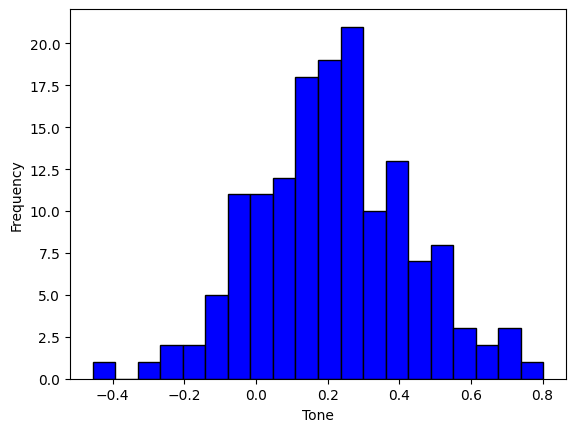

In [15]:
# Plotting the histogram
plt.hist(df['tone'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Tone')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

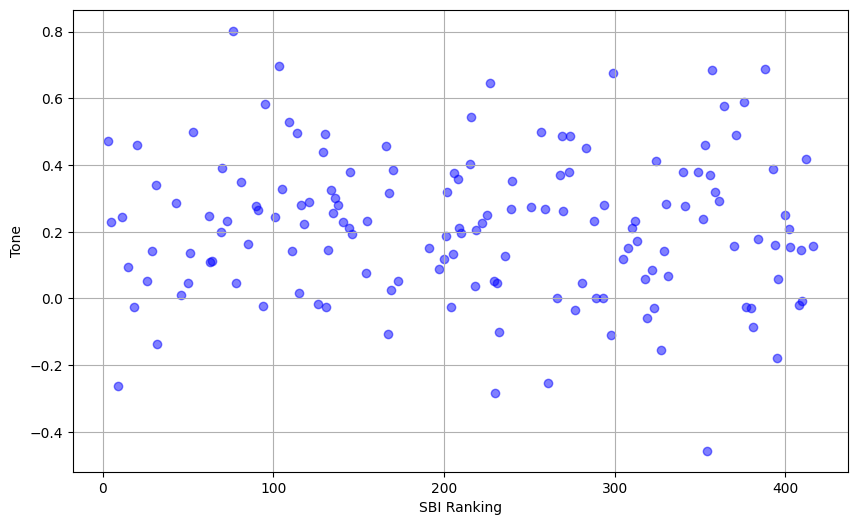

In [7]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['ranking'], df['tone'], color='blue', alpha=0.5)

# Adding titles and labels
plt.xlabel('SBI Ranking')
plt.ylabel('Tone')

# Show the plot
plt.grid(True)
plt.show()

# 11 Logarithmize Firm Size & Standardize IV

In [46]:
# Load the CSV file
df = pd.read_csv('report_table_final.csv')

# Create dummy variables for the sectors
df_dummies = pd.get_dummies(df['industry'], drop_first=True)

# Ensuring dummy variables are in 0 and 1 format explicitly
df_dummies = df_dummies.astype(int)

# Merge the dummies back into the original DataFrame
df = pd.concat([df, df_dummies], axis=1)

sector_to_sector_renaming = {
    "Consumer Staples": "consumer_staples",
    "Industrials": "industrials",
    "Financials": "financials",
    "Information Technology": "information_technology"
}

df.rename(columns=sector_to_sector_renaming, inplace=True)

# Convert 'roa' to string, replace commas with periods, then convert to float
df['roa'] = df['roa'].map(lambda r: float(r.replace(',', '.')))

# Apply natural logarithm to 'total_assets'
df['total_assets'] = np.log(df['total_assets'])

# Initialize the scaler
scaler = StandardScaler()
                                              
# List of variables to standardize, including the industry dummies and 'publicly_traded'
vars_to_standardize = ['ranking', 'total_assets', 'roa',
                       'consumer_staples', 'industrials', 'financials', 'information_technology', 'publicly_traded']

# Standardize the variables
df[vars_to_standardize] = scaler.fit_transform(df[vars_to_standardize])

df.to_csv('report_table_transformation.csv', index=False)

# 12 Correlation Matrix

In [60]:
# Load the data
data = pd.read_csv('report_table_transformation.csv')

# Select the columns of interest
columns_of_interest = ['ranking', 'total_assets', 'roa', 'consumer_staples', 
                       'industrials', 'financials', 'information_technology', 'publicly_traded']
data = data[columns_of_interest]

# Calculate the Pearson Correlation Matrix
correlation_matrix = data.corr(method='pearson')

# Calculate the p-values
p_values = pd.DataFrame(index=correlation_matrix.columns, columns=correlation_matrix.columns)
for row in correlation_matrix.columns:
    for col in correlation_matrix.columns:
        p_values[row][col] = stats.pearsonr(data[row], data[col])[1]

# Print the correlation matrix and the matrix of p-values
print("Correlation Matrix:\n", correlation_matrix)
print("\nP-Values Matrix:\n", p_values)

Correlation Matrix:
                          ranking  total_assets       roa  consumer_staples  \
ranking                 1.000000      0.262565  0.096874         -0.040737   
total_assets            0.262565      1.000000  0.156769         -0.108071   
roa                     0.096874      0.156769  1.000000          0.038896   
consumer_staples       -0.040737     -0.108071  0.038896          1.000000   
industrials             0.190216      0.040881 -0.016453         -0.189873   
financials              0.022258      0.250466 -0.035140         -0.170396   
information_technology -0.142973      0.070026  0.072370         -0.117502   
publicly_traded         0.138623      0.529409  0.106344         -0.055889   

                        industrials  financials  information_technology  \
ranking                    0.190216    0.022258               -0.142973   
total_assets               0.040881    0.250466                0.070026   
roa                       -0.016453   -0.035140    

/tmp/ipykernel_110/877197674.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  p_values[row][col] = stats.pearsonr(data[row], data[col])[1]


# 13 Regression

In [47]:
# Load the CSV file
df = pd.read_csv('report_table_transformation.csv')

# Calculate 'tone'
df['tone'] = (df['total_positive_word_count'] - df['total_negative_word_count']) / (df['total_positive_word_count'] + df['total_negative_word_count'])

In [48]:
# Define independent variables for the control model (including the industry dummies but excluding 'Consumer Discretionary')
control_vars = ['total_assets', 'roa', 
                'consumer_staples', 'industrials', 'financials', 'information_technology', 'publicly_traded']
X_control = df[control_vars]
y = df['tone']

# Add a constant to the control model (intercept)
X_control = sm.add_constant(X_control)

# Fit the OLS model for the control variables
model_control = sm.OLS(y, X_control).fit()

# Get the residuals from the control model
residuals_control = model_control.resid

# Calculate the residual sum of squares (RSS)
rss = np.sum(residuals_control ** 2)

# Print out the summary of the control model
print("Control Model Summary:")
print(model_control.summary())

# Print out the RSS
print("\nResidual Sum of Squares (RSS) of the control model:", rss)

Control Model Summary:
                            OLS Regression Results                            
Dep. Variable:                   tone   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.459
Date:                Sun, 21 Apr 2024   Prob (F-statistic):              0.187
Time:                        18:34:04   Log-Likelihood:                 23.159
No. Observations:                 150   AIC:                            -30.32
Df Residuals:                     142   BIC:                            -6.233
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const

In [49]:
# Define independent variables for the full model by adding 'ranking'
full_vars = ['ranking']  + control_vars  # Adding 'ranking' to the control variables
X_full = df[full_vars]

# Add a constant to the full model (intercept)
X_full = sm.add_constant(X_full)

# Fit the OLS model for the full model
model_full = sm.OLS(y, X_full).fit()

# Get the residuals from the full model
residuals_full = model_full.resid

# Calculate the residual sum of squares (RSS)
rss = np.sum(residuals_full ** 2)

# Get the MSE from the model results
mse = model_full.mse_resid

# Print out the summary of the full model
print("\nFull Model Summary:")
print(model_full.summary())

# Print out the RSS
print("\nResidual Sum of Squares (RSS) of the full model:", rss)

# Print out the MSE
print("\nMean Squared Error (MSE) of the residuals:", mse)


Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:                   tone   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.432
Date:                Sun, 21 Apr 2024   Prob (F-statistic):              0.188
Time:                        18:34:14   Log-Likelihood:                 23.810
No. Observations:                 150   AIC:                            -29.62
Df Residuals:                     141   BIC:                            -2.524
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const  

In [50]:
# Calculate the F-statistic without using built-in functions
rss_full = model_full.ssr  # Residual sum of squares for the full model
rss_control = model_control.ssr  # Residual sum of squares for the control model
df_full = model_full.df_resid  # Degrees of freedom for the full model residuals
df_control = model_control.df_resid  # Degrees of freedom for the control model residuals

# Number of parameters added
num_params_added = df_control - df_full

# Calculate F-statistic
f_stat_custom = ((rss_control - rss_full) / num_params_added) / (rss_full / df_full)

# Calculate p-value using the F-distribution
from scipy.stats import f
p_value_custom = 1 - f.cdf(f_stat_custom, num_params_added, df_full)

# Print F-statistic and p-value
print(f"Calculated F-statistic: {f_stat_custom}, p-value: {p_value_custom}")

# Interpret the F-test results
if p_value_custom < 0.05:
    print("Adding 'ranking' significantly improves the model, indicating it's a significant predictor of 'tone'.")
else:
    print("Adding 'ranking' does not significantly improve the model's explanatory power.")

Calculated F-statistic: 1.2294395200714678, p-value: 0.2694037300392218
Adding 'ranking' does not significantly improve the model's explanatory power.


In [51]:
# Significance level (alpha)
alpha = 0.05

# Degrees of freedom for the numerator (the number of additional predictors)
dfn = 1

# Degrees of freedom for the denominator (total observations minus the number of parameters in the full model)
dfd = 150 - 8 - 1

# Calculate the critical F-value
critical_f_value = f.ppf(1 - alpha, dfn, dfd)

print("Critical F-value:", critical_f_value)

Critical F-value: 3.908258110753643


In [52]:
from scipy.stats import t

# Significance level (alpha) for a two-tailed test
alpha = 0.05

# Degrees of freedom for the t-distribution
dfd = 150-8-1

# Calculate the critical t-value for a two-tailed test
critical_t_value = t.ppf(1 - alpha/2, dfd)

print("Critical t-value:", critical_t_value)

Critical t-value: 1.9769314886210219


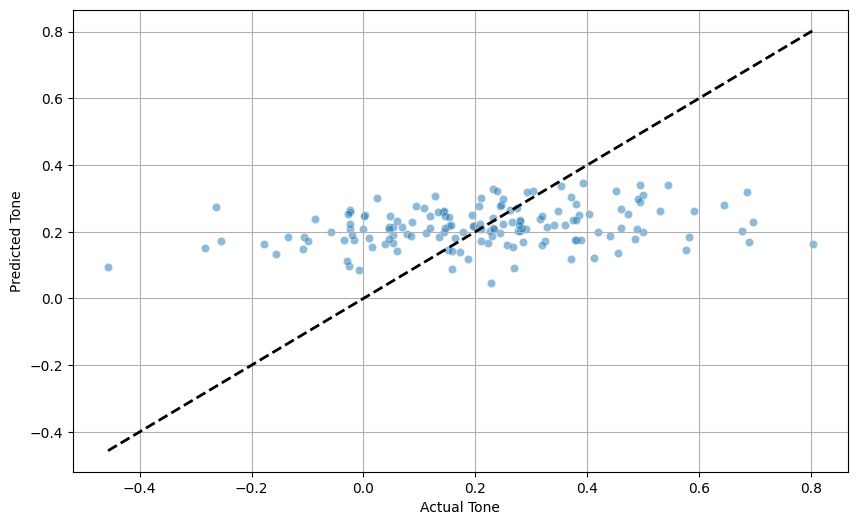

In [53]:
# Predict 'tone' using the full model
predicted_vals_full = model_full.predict(X_full)

# Plotting actual vs predicted values for the full model
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=predicted_vals_full, alpha=0.5)  # Actual vs. Predicted 'tone'
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Reference line for perfect predictions
plt.xlabel('Actual Tone')
plt.ylabel('Predicted Tone')
plt.grid(True)
plt.show()

# 14 Diagnostics

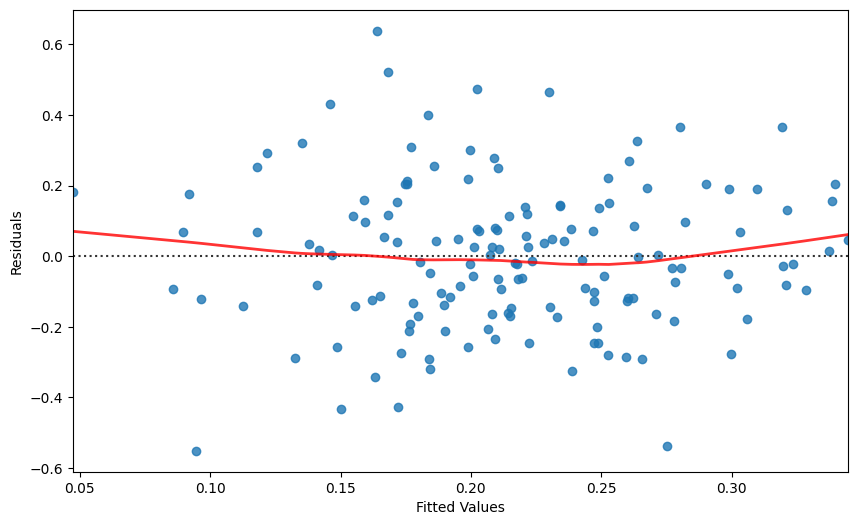

In [54]:
# Get the residuals and fitted values from the full model
residuals_full = model_full.resid
fitted_vals_full = model_full.fittedvalues

# Plotting residuals vs fitted values for the full model
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted_vals_full, y=residuals_full, lowess=True, 
              line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In [55]:
from statsmodels.stats.diagnostic import linear_reset

# Perform the Ramsey RESET test
reset_test = linear_reset(model_full, power=3, use_f=True)

print(reset_test)

<F test: F=0.745786588609246, p=0.4762494231220029, df_denom=139, df_num=2>


In [56]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Perform the Breusch-Pagan test
bp_test_full = het_breuschpagan(residuals_full, X_full)

# Print the results for the full model
labels = ['BP Statistic', 'BP Test p-value']
print("Breusch-Pagan test results:")
print(dict(zip(labels, bp_test_full[:2])))

Breusch-Pagan test results:
{'BP Statistic': 9.604868289914336, 'BP Test p-value': 0.29386084786674077}


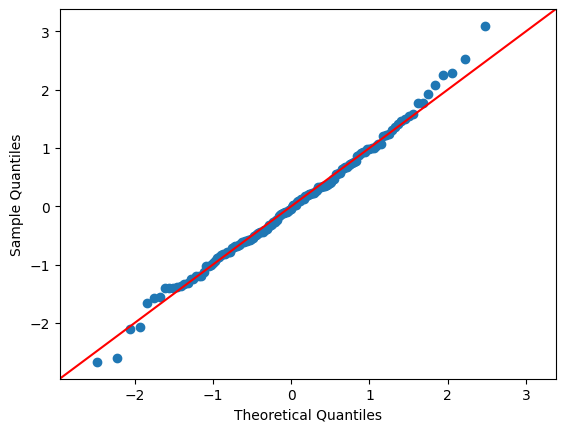

In [57]:
# Create a Q-Q plot for the full model residuals
fig = sm.qqplot(residuals_full, line='45', fit=True)
plt.show()

In [58]:
from scipy import stats
import statsmodels.api as sm

# Standardize the residuals
residuals_standardized_full = (residuals_full - residuals_full.mean()) / residuals_full.std()

# Perform the Kolmogorov-Smirnov test for normality on the standardized residuals
ks_statistic_full, ks_pvalue_full = stats.kstest(residuals_standardized_full, 'norm')

print(f'Kolmogorov-Smirnov statistic: {ks_statistic_full}')
print(f'P-value: {ks_pvalue_full}')

Kolmogorov-Smirnov statistic: 0.04095851444859999
P-value: 0.9539731785755263


In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each independent variable
vif_data_full = pd.DataFrame()
vif_data_full['Feature'] = X_full.columns
# We need to ensure we're using the correct DataFrame for VIF calculation
vif_data_full['VIF'] = [variance_inflation_factor(X_full.values, i) for i in range(X_full.shape[1])]

# Display the VIF results
print(vif_data_full)

                  Feature       VIF
0                   const  1.000000
1                 ranking  1.148134
2            total_assets  1.612929
3                     roa  1.043553
4        consumer_staples  1.110473
5             industrials  1.114828
6              financials  1.156533
7  information_technology  1.082457
8         publicly_traded  1.412091
